In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
b = pd.read_csv("/content/sample_data/csv_building_structure.csv")
df = pd.read_csv("/content/sample_data/ward_vdcmun_district_name_mapping.csv")

In [ ]:
df=df[['district_id','district_name']]

In [ ]:
# prompt: df'deki district_id'si ve district_name'i aynı olan satırları siler misin
df = df.drop_duplicates(subset=['district_id', 'district_name'], keep='first')

In [ ]:
b = b.dropna(subset=['damage_grade'])

In [ ]:
today = datetime.date.today()

year = today.year

b['building_creation_year'] = 2015 - b['age_building']

In [ ]:
for column in b.columns:
  if b[column].dtype == 'float64':
    b[column] = b[column].fillna(0).astype(int)

In [ ]:
def extract_grade_number(grade):
  if pd.isnull(grade):
    return np.nan
  else:
    return int(grade.split()[-1])

b['damage_grade'] = b['damage_grade'].apply(extract_grade_number)

In [ ]:
# yüksekliğe göre silme
b = b.drop(b[(b['damage_grade'] == 5) & ((b['height_ft_pre_eq'] == b['height_ft_post_eq']) | (b['count_floors_pre_eq'] == b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 4) & ((b['height_ft_pre_eq'] == b['height_ft_post_eq']) | (b['count_floors_pre_eq'] == b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 1) & ((b['height_ft_pre_eq'] != b['height_ft_post_eq']) & (b['count_floors_pre_eq'] != b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 3) & ((b['height_ft_pre_eq'] == 0) | (b['count_floors_pre_eq'] == 0))].index)
b = b.drop(b[(b['damage_grade'] != 5) & ((b['height_ft_pre_eq'] == 0) | (b['count_floors_pre_eq'] == 0))].index)
b = b[b['building_creation_year'] <= 2010]
# teknik çözüme göre silme
b = b.drop(b[(b['damage_grade'] == 1) & ((b['height_ft_pre_eq'] > b['height_ft_post_eq']) | (b['count_floors_pre_eq'] > b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] <= 2) & (b['technical_solution_proposed'] == 'Reconstruction')].index)
b = b.drop(b[(b['damage_grade'] <= 2) & (b['technical_solution_proposed'] == 'Major repair')].index)
b = b.drop(b[(b['damage_grade'] == 5) & (b['technical_solution_proposed'] != 'Reconstruction')].index)
b = b.drop(b[(b['damage_grade'] == 4) & (b['technical_solution_proposed'] == 'Minor repair')].index)
b = b.drop(b[(b['age_building'] > 50) & (b['damage_grade'] == 2)].index)
b = b.drop(b[(b['condition_post_eq'] == 'Damaged-Used in risk') & (b['damage_grade'] == 5)].index)

In [ ]:
# prompt: b ile df verisetlerini district_id ile birleştirip yeni veri setine df'den sadece district_name ekleyeceksin
merged_df = pd.merge(b, df[['district_id', 'district_name']], on='district_id', how='left')

In [ ]:
merged_df.loc[merged_df['district_name'] == 'Okhaldhunga', 'magnitude_felt'] = 1
merged_df.loc[merged_df['district_name'] == 'Okhaldhunga', 'magnitude'] = 5.5
merged_df.loc[merged_df['district_name'] == 'Sindhuli', 'magnitude_felt'] = 5
merged_df.loc[merged_df['district_name'] == 'Sindhuli', 'magnitude'] = 6.25
merged_df.loc[merged_df['district_name'] == 'Ramechhap', 'magnitude_felt'] = 20
merged_df.loc[merged_df['district_name'] == 'Ramechhap', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Dolakha', 'magnitude_felt'] = 80
merged_df.loc[merged_df['district_name'] == 'Dolakha', 'magnitude'] = 7.3
merged_df.loc[merged_df['district_name'] == 'Sindhupalchok', 'magnitude_felt'] = 40
merged_df.loc[merged_df['district_name'] == 'Sindhupalchok', 'magnitude'] = 7.0
merged_df.loc[merged_df['district_name'] == 'Kavrepalanchok', 'magnitude_felt'] = 18
merged_df.loc[merged_df['district_name'] == 'Kavrepalanchok', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Nuwakot', 'magnitude_felt'] = 30
merged_df.loc[merged_df['district_name'] == 'Nuwakot', 'magnitude'] = 6.9
merged_df.loc[merged_df['district_name'] == 'Rasuwa', 'magnitude_felt'] = 20
merged_df.loc[merged_df['district_name'] == 'Rasuwa', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Dhading', 'magnitude_felt'] = 40
merged_df.loc[merged_df['district_name'] == 'Dhading', 'magnitude'] = 7.0
merged_df.loc[merged_df['district_name'] == 'Makwanpur', 'magnitude_felt'] = 11
merged_df.loc[merged_df['district_name'] == 'Makwanpur', 'magnitude'] = 6.5
merged_df.loc[merged_df['district_name'] == 'Gorkha', 'magnitude_felt'] = 250
merged_df.loc[merged_df['district_name'] == 'Gorkha', 'magnitude'] = 7.8

In [ ]:
b=merged_df

In [ ]:
result_df_1 = b[(b['age_building'] > 70) & (b['count_floors_pre_eq'] >= 3) & (b['height_ft_post_eq'] != 0) & (b['damage_grade'] == 3)]
b = b.drop(result_df_1.index)
result_df_2 = b[(b['age_building'] > 100) & (b['count_floors_pre_eq'] >= 2) & (b['height_ft_post_eq'] != 0) & (b['damage_grade'] == 3)]
b = b.drop(result_df_2.index)
result_df_3 = b[(b['age_building'] > 70) & (b['magnitude'] >= 6) & (b['damage_grade'] == 1)]
b = b.drop(result_df_3.index)
result_df_4 = b[(b['age_building'] > 130)]
b = b.drop(result_df_4.index)
result_df_5 = b[(b['plinth_area_sq_ft'] > 700)]
b = b.drop(result_df_5.index)
result_df_6 = b[(b['height_ft_pre_eq'] >= 40)]
b = b.drop(result_df_6.index)

In [ ]:
# prompt: damage_grade'i 2 ve 3 olanları 2, 4 ve 5 olanları 3 yapar mısın

b.loc[b['damage_grade'].isin([2, 3]), 'damage_grade'] = 2
b.loc[b['damage_grade'].isin([4, 5]), 'damage_grade'] = 3

In [ ]:
pd.set_option('display.max_columns', 500)
#b[['damage_grade', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'land_surface_condition', 'roof_type', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other']]
b

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,building_creation_year,district_name,magnitude_felt,magnitude
0,120101000011,12,1207,120703,1,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Used in risk,2,Major repair,2006,Okhaldhunga,1.0,5.5
1,120101000031,12,1207,120703,1,1,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,2,Minor repair,1995,Okhaldhunga,1.0,5.5
2,120101000041,12,1207,120703,1,1,20,312,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,2,Minor repair,1995,Okhaldhunga,1.0,5.5
3,120101000051,12,1207,120703,1,1,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,1,Minor repair,1985,Okhaldhunga,1.0,5.5
4,120101000061,12,1207,120703,1,1,18,216,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Used in risk,2,Minor repair,1997,Okhaldhunga,1.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444853,312802000171,31,3107,310701,2,2,6,360,12,12,Flat,Bamboo/Timber,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,1,0,0,0,0,Not damaged,1,No need,2009,Makwanpur,11.0,6.5
444854,312802000181,31,3107,310701,3,3,14,416,13,13,Flat,Bamboo/Timber,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,1,0,0,0,0,Damaged-Repaired and used,2,Minor repair,2001,Makwanpur,11.0,6.5
444855,312802000191,31,3107,310701,3,3,9,350,13,13,Flat,Bamboo/Timber,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,1,0,0,0,0,Damaged-Repaired and used,1,No need,2006,Makwanpur,11.0,6.5
444856,312802000201,31,3107,310701,2,2,5,210,7,7,Flat,Bamboo/Timber,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,0,0,0,0,0,0,0,0,0,1,Not damaged,1,No need,2010,Makwanpur,11.0,6.5


In [ ]:
b = pd.read_csv("/content/sample_data/data.csv")

In [ ]:
b

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,building_creation_year,district_name,magnitude_felt,magnitude
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0.0,0.0,0.0,Damaged-Used in risk,2.0,Major repair,2006.0,Okhaldhunga,1.0,5.5
1,120101000031,12,1207,120703,1,1,20,384,9,9,...,0.0,0.0,0.0,Damaged-Repaired and used,2.0,Minor repair,1995.0,Okhaldhunga,1.0,5.5
2,120101000041,12,1207,120703,1,1,20,312,9,9,...,0.0,0.0,0.0,Damaged-Repaired and used,2.0,Minor repair,1995.0,Okhaldhunga,1.0,5.5
3,120101000051,12,1207,120703,1,1,30,308,9,9,...,0.0,0.0,0.0,Damaged-Repaired and used,1.0,Minor repair,1985.0,Okhaldhunga,1.0,5.5
4,120101000061,12,1207,120703,1,1,18,216,9,9,...,0.0,0.0,0.0,Damaged-Used in risk,2.0,Minor repair,1997.0,Okhaldhunga,1.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174329,234601003122,23,2301,230108,1,0,55,280,8,0,...,0.0,0.0,0.0,Damaged-Rubble unclear,3.0,Reconstruction,1960.0,Sindhupalchok,40.0,7.0
174330,234601003131,23,2301,230108,1,0,15,234,15,0,...,0.0,0.0,0.0,Damaged-Rubble Clear-New building built,3.0,Reconstruction,2000.0,Sindhupalchok,40.0,7.0
174331,234601003141,23,2301,230108,1,0,19,336,8,0,...,0.0,0.0,0.0,Damaged-Rubble clear,3.0,Reconstruction,1996.0,Sindhupalchok,40.0,7.0
174332,234601003151,23,2301,230108,1,0,20,396,9,0,...,0.0,0.0,0.0,Damaged-Rubble clear,3.0,Reconstruction,1995.0,Sindhupalchok,40.0,7.0


In [ ]:
# prompt: herhangi bir sütunu boş olan satırları silen kod (b için)

# Assuming 'b' is your DataFrame
b = b.dropna()

<ipython-input-14-6b67cd3e12d2>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-14-6b67cd3e12d2>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-14-6b67cd3e12d2>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

XGBoost Accuracy: 0.757
Random Forest Accuracy: 0.797


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.645


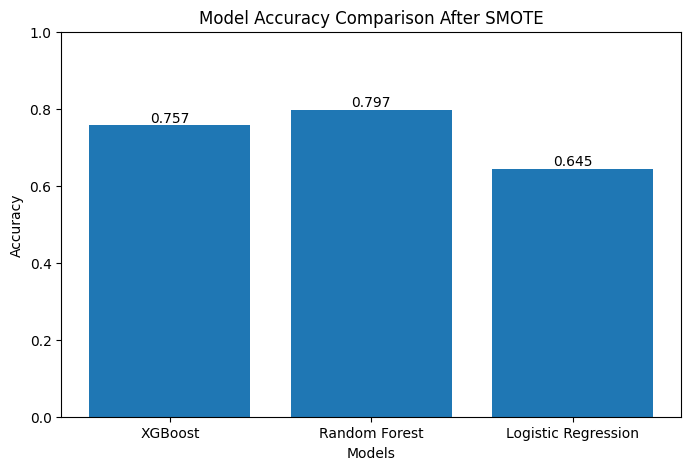

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
import matplotlib.pyplot as plt

data = b

# Özellikler ve hedef değişken
features = [
    "plinth_area_sq_ft",
    "magnitude_felt",
    "magnitude",
    "land_surface_condition",
    "count_floors_pre_eq",
    "height_ft_pre_eq",
    "roof_type",
    "age_building",
    "foundation_type",
    "ground_floor_type",
    "other_floor_type",
    "has_superstructure_adobe_mud",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
]

target = "damage_grade"

X = data[features]
y = data[target] - 1

# Kategorik değişkenleri dönüştürme
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# SMOTE ile dengesizlik giderme
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Model eğitim ve değerlendirme
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", round(xgb_accuracy, 3))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", round(rf_accuracy, 3))

# Logistic Regression
logr = linear_model.LogisticRegression(max_iter=500)
logr.fit(X_train, y_train)
logr_predictions = logr.predict(X_test)
logr_accuracy = accuracy_score(y_test, logr_predictions)
print("Logistic Regression Accuracy:", round(logr_accuracy, 3))

# Doğruluk oranlarını görselleştirme
model_names = ['XGBoost', 'Random Forest', 'Logistic Regression']
accuracies = [xgb_accuracy, rf_accuracy, logr_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison After SMOTE")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.bar_label(plt.bar(model_names, accuracies), fmt='%.3f')
plt.show()

In [ ]:
# prompt: can you guess damage_grade column with columns [magnitude_felt, has_superstructure_adobe_mud, has_superstructure_mud_mortar_stone, has_superstructure_stone_flag, has_superstructure_cement_mortar_stone, has_superstructure_mud_mortar_brick, has_superstructure_cement_mortar_brick, has_superstructure_timber, land_surface_condition, roof_type, foundation_type, roof_type, ground_floor_type, other_floor_type, has_superstructure_bamboo, has_superstructure_rc_non_engineered, has_superstructure_rc_engineered, has_superstructure_other]
# with the models XGBOOST and RNN and Random Forest and print accurracy values
# and make magnitude_felt, floor_type, roof_type columns more important than the others

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
# ... (Your existing code) ...

# Assuming your DataFrame is named 'b' and the code you provided has been executed
data = b

# Select features and target variable
features = [
    "plinth_area_sq_ft",
    "magnitude_felt",
    "magnitude",
    "land_surface_condition",
    "count_floors_pre_eq",
    "height_ft_pre_eq",
    "roof_type",
    "age_building",
    "foundation_type",
    "ground_floor_type",
    "other_floor_type",
    "has_superstructure_adobe_mud",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
]

target = "damage_grade"

X = data[features]
y = data[target] - 1

# Convert categorical features to numerical using Label Encoding
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to store feature weights
feature_weights = {
    "magnitude_felt": 5,
    "magnitude": 4,
    "roof_type": 2,
    "age_building":3,
    "ground_floor_type": 2,
    "other_floor_type": 2,
    "foundation_type":3,
    "has_superstructure_cement_mortar_stone":4,
    "has_superstructure_mud_mortar_brick":4,
    "has_superstructure_cement_mortar_brick":4,
}

# Assign weights to features in X_train and X_test
for feature, weight in feature_weights.items():
    if feature in X_train.columns:
        X_train[feature] = X_train[feature] * weight
    if feature in X_test.columns:
        X_test[feature] = X_test[feature] * weight


# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", round(xgb_accuracy, 3))



# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", round(rf_accuracy, 3))

# LogisticRegression
logr = linear_model.LogisticRegression()
logr.fit(X,y)
logr_predictions = logr.predict(X_test)
logr_accuracy = accuracy_score(y_test, logr_predictions)
print("Logistic Regression Accuracy:", round(logr_accuracy, 3))


import matplotlib.pyplot as plt

# Doğruluk değerlerini listeye ekle
model_names = ['XGBoost', 'Random Forest','Logistic Regression']
accuracies = [xgb_accuracy, rf_accuracy,logr_accuracy]

# Grafik oluştur
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)  # Doğruluk oranları 0-1 arasında olduğundan eksen sınırlarını ayarlayın
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(model_names)
plt.bar_label(plt.bar(model_names, accuracies), fmt='%.3f')  # Doğrulukları sütun üzerinde göster
plt.show()

<ipython-input-9-e8c62d7f7bb8>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-9-e8c62d7f7bb8>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-9-e8c62d7f7bb8>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [ 0.  1.  2. nan]

<ipython-input-35-927f8e1eb11a>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-35-927f8e1eb11a>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-35-927f8e1eb11a>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

XGBoost Accuracy: 0.761
Random Forest Accuracy: 0.799


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

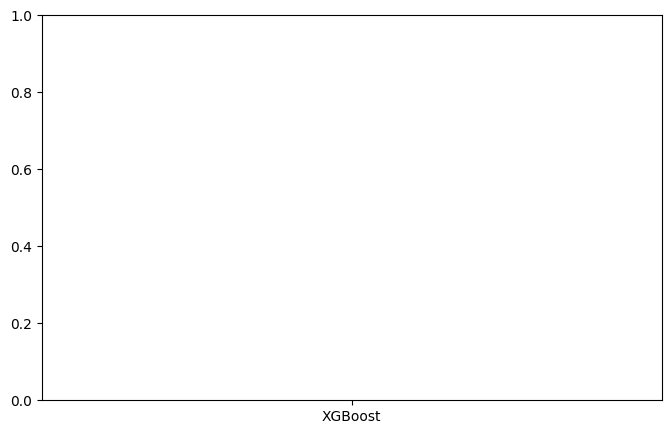

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
import matplotlib.pyplot as plt

# Özellikler ve hedef değişken
features = [
    "plinth_area_sq_ft",
    "magnitude_felt",
    "magnitude",
    "land_surface_condition",
    "count_floors_pre_eq",
    "height_ft_pre_eq",
    "roof_type",
    "age_building",
    "foundation_type",
    "ground_floor_type",
    "other_floor_type",
    "has_superstructure_adobe_mud",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
]

target = "damage_grade"

X = data[features]
y = data[target] - 1

# Kategorik değişkenleri dönüştürme
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])


# Yeni Özellikler Türetme
X['damage_potential'] = X['magnitude_felt'] * X['age_building']
X['structure_risk'] = X['count_floors_pre_eq'] / (X['height_ft_pre_eq'] + 1)  # Sıfıra bölünmeyi önlemek için +1
X['foundation_age_interaction'] = X['foundation_type'] * X['age_building']

# SMOTE Sonrası Eğitim ve Test Seti Ayırma
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# XGBoost Modeli
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", round(xgb_accuracy, 3))

# Random Forest Modeli
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", round(rf_accuracy, 3))

# Doğruluk Oranlarını Görselleştirme
model_names = ['XGBoost', 'Random Forest']
accuracies = [xgb_accuracy, rf_accuracy, logr_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison with Feature Engineering")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.bar_label(plt.bar(model_names, accuracies), fmt='%.3f')
plt.show()
